# Imports

In [38]:
import importlib
import functions as f  # Our defined functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
from tqdm.notebook import tqdm
import os
import math
import time

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

importlib.reload(f)

GRatio = (1 + 5 ** .5) / 2

WIDTH = .5
DASH = (10, 10)


# Solving models

Model verified.
Writing model to file models/SIRS_vars.json.
File name already exists.
Overwriting file.


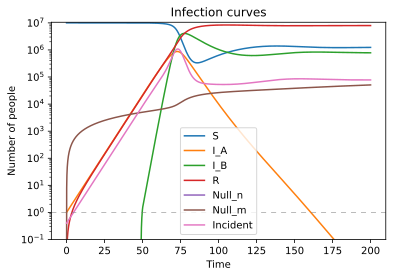

Pop variation: -31057

Computation of R0
Model verified.
Writing model to file models/SIRS_vars.json.
File name already exists.
Overwriting file.

Creating new model!
New model created in 0.0e+00 seconds.

Véfication faite, les deux modèles sont identiques.
R0 computation done

{'Rt(S,I_A)': 1.997995852338581, 'Rt(S,I_B)': 0.0}
Model verified.
Writing model to file models/SIRS_deaths.json.
File name already exists.
Overwriting file.


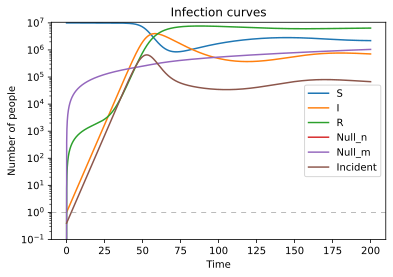

Pop variation: -648674

Computation of R0
Model verified.
Writing model to file models/SIRS_deaths.json.
File name already exists.
Overwriting file.

Creating new model!
New model created in 0.0e+00 seconds.

Véfication faite, les deux modèles sont identiques.
R0 computation done

{'Rt(S,I)': 3.938826145525068}


In [43]:
importlib.reload(f)

for modelName in ['SIRS_vars', 'SIRS_deaths']:

    model = f.loadModel(modelName)
    solution, t_span = f.solve(model, (0, 200), 100)

    # SIRS_deaths2 = f.mod(SIRS_deaths)
    # solution2, t_span2 = f.solve(SIRS_deaths2, (0, 200), 100)

    fig = plt.figure()
    f.plotCurves(t_span,
                np.transpose(solution),
                toPlot=list(range(solution.shape[1])),
                labels=f.getCompartments(model))
    plt.plot(t_span, f.infCurve(model, solution, t_span), label='Incident')
    plt.ylim(bottom=.1)
    plt.legend(loc='best')
    plt.axhline(y=1, linestyle='--', color='grey', linewidth=WIDTH, dashes=DASH)
    plt.yscale('log')
    plt.show()

    popChange = f.getPopChange(model, solution)
    print(f"Pop variation: {popChange:.0f}")

    f.mod(model)

    model, modelMod, _, r0 = f.computeR0(
        modelName, (0, 300), printInit=False, printWarnings=False,
        scaledInfs=False)

    print(r0)


# $\mathcal{R}_t$ curves

Initializing with values {'S': 9691544.09, 'I_A': 150996.14, 'I_B': 1174.49, 'R': 156137.79, 'Null_n': -6001.0, 'Null_m': 6148.49}.



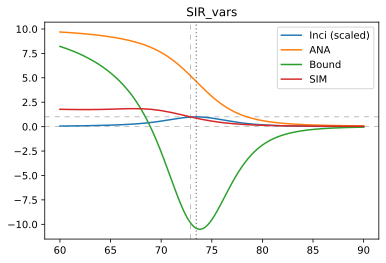

In [4]:
importlib.reload(f)

rtCurves, newInfs, rt_ANA = f.compare(
    "SIR_vars", (60, 90), R0=10, write=True, printInit=True,
    susceptibles=[0], infected=[1, 2], plotIndividual=False)
plt.show()


Model verified.
Writing model to file models/SIR.json.
File name already exists.
Overwriting file.
Model took 3.0e-02 seconds to solve.



Found a problem with beta = 0.075 and gamma = 0.05.


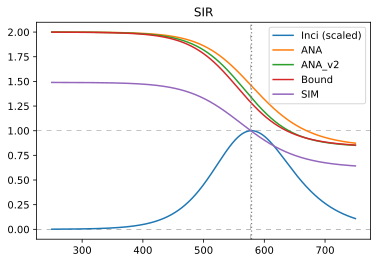

In [36]:
importlib.reload(f)

rtPrecision = 5

SIR = f.loadModel('SIR')
SIR['flows']['flows'][0]['parameter'] = str(.075)
SIR['flows']['flows'][1]['parameter'] = str(.05)
f.writeModel(SIR, True, False)
SIR = f.loadModel('SIR', printText=False)

solution, t_span = f.solve(SIR, (0, 500), 100, True)
infsCurve = f.infCurveScaled(SIR, solution, t_span)
timeMax = t_span[f.find_nearest(infsCurve, 1)]

t_min = math.floor(timeMax / 2 * rtPrecision) / rtPrecision
t_max = math.ceil(3 * timeMax / 2 * rtPrecision) / rtPrecision

rtCurves = \
    f.compare("SIR", (t_min, t_max), rtPrecision, R0=2,
              plotANA=True, plotANA_v2=True,
              susceptibles=[0], infected=[1],
              plotBound=True)

plt.show()


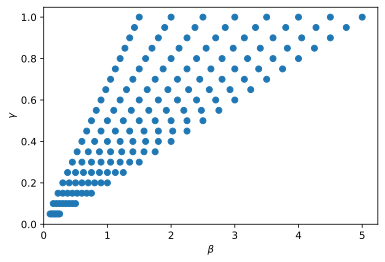

In [61]:
importlib.reload(f)

if os.path.isfile('problems.txt'):
    os.remove('problems.txt')

rtPrecision = 5
timeMaxMax = 500
tested = None

for R0 in tqdm(np.arange(1.5, 5 + .5, .5), desc='Values for R0'):
    for gamma in tqdm(np.arange(.05, 1 + .05, .05), leave=False, desc=f'R0 = {R0}'):
        beta = R0 * gamma
        if beta >= 0:  # always true
            # print(beta, gamma, R0)
            SIR = f.loadModel('SIR', printText=False)
            SIR['flows']['flows'][0]['parameter'] = str(beta)
            SIR['flows']['flows'][1]['parameter'] = str(gamma)
            f.writeModel(SIR, True, False)
            SIR = f.loadModel('SIR', printText=False)

            solution, t_span = f.solve(SIR, (0, timeMaxMax), 100, False)
            infsCurveScaled = f.infCurveScaled(SIR, solution, t_span)
            timeMax = t_span[f.find_nearest(infsCurveScaled, 1)]

            if timeMax >= timeMaxMax - 1:
                # If maximum is not reached, we don't want to analyse
                continue

            # print(f'Time max infections: {timeMax}')

            t_min = math.floor(max(
                timeMax / 2,
                timeMax - 50
            ) * rtPrecision) / rtPrecision
            t_max = math.ceil(min(
                3 * timeMax / 2,
                timeMax + 50
            ) * rtPrecision) / rtPrecision

            rtCurves = \
                f.compare("SIR", (t_min, t_max), 1, R0=R0,
                          plotANA=True, plotANA_v2=True,
                          susceptibles=[0], infected=[1],
                          plotBound=True, supressGraph=True,
                          useTqdm=False)

            if type(tested) == type(None):
                tested = np.array([[beta, gamma]])
            else:
                tested = np.append(tested, [[beta, gamma]], axis=0)

plt.plot(tested[:, 0], tested[:, 1], 'o')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('$\\beta$')
plt.ylabel('$\\gamma$')
plt.show()


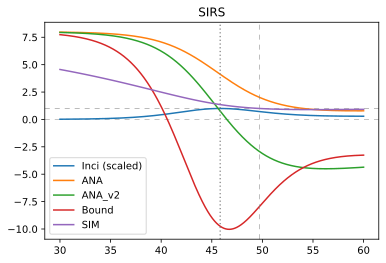

In [65]:
importlib.reload(f)

name = 'SIRS'
# model = f.loadModel(name)
# solution, t_span = f.solve(model, (0, 300), 100)

# fig = plt.figure()
# f.plotCurves(t_span,
#              np.transpose(solution),
#              toPlot=list(range(solution.shape[1])),
#              labels=f.getCompartments(model))
# # plt.yscale('log')
# plt.ylim(bottom=.1)
# plt.show()

rtCurves = \
    f.compare(name, (30, 60), 2, R0=8,
              plotANA=True, plotANA_v2=True,
              susceptibles=[0], infected=[1])
plt.show()


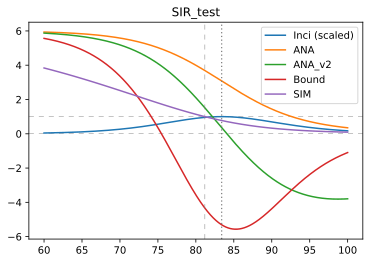

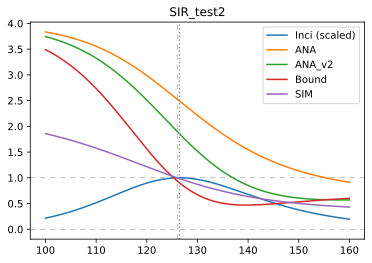

In [67]:
importlib.reload(f)

rtTimes, rtCurves, infsNotScaled = \
    f.compare("SIR_test", (60, 100), 1, R0=6,
              whereToAdd='to', plotANA=True, plotANA_v2=True,
              susceptibles=[0], infected=[1, 2, 3])
plt.show()

rtTimes, rtCurves, infsNotScaled = \
    f.compare("SIR_test2", (100, 160), 1, R0=4,
              whereToAdd='to', plotANA=True, plotANA_v2=True,
              susceptibles=[0], infected=[1, 2])
plt.show()


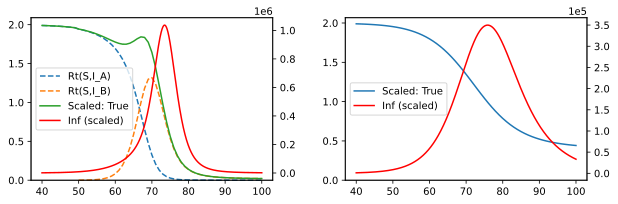

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

model, newModel, solution, t_span, values = f.computeRt(
    'SIR_vars', (40, 100), sub_rt=1,
    scaledInfs=True, write=False, printText=False,
    printInit=False, printWarnings=False)

rt_times = np.array([key for key in values])
rt = np.zeros_like(rt_times, dtype='float64')
for rtNode in f.getRtNodes(f.mod(model, False, False)):
    rt_rtNode = np.array([values[key][rtNode] for key in values])

    idx = np.where(rt_rtNode > 0)
    if len(f.getRtNodes(f.mod(model, False, False))) > 1:
        ax1.plot(rt_times[idx], rt_rtNode[idx], label=rtNode, linestyle='--')
    rt += rt_rtNode


idx = np.where(rt > 0)
ax1.plot(rt_times[idx], rt[idx], label=f'Scaled: {True}')

ax1.set_ylim(bottom=0)

ax3 = ax1.twinx()
infsScaled = f.infCurve(model, solution, t_span)
ax3.plot(t_span, infsScaled, label='Inf (scaled)', c='Red')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()

ax1.legend(lines + lines2, labels + labels2, loc='center left')

# -------------------

model, newModel, solution, t_span, values = f.computeRt(
    'SIR_vars_noB', (40, 100), sub_rt=1,
    scaledInfs=True, write=False, printText=False,
    printInit=False, printWarnings=False)

rt_times = np.array([key for key in values])
rt = np.zeros_like(rt_times, dtype='float64')
for rtNode in f.getRtNodes(f.mod(model, False, False)):
    rt_rtNode = np.array([values[key][rtNode] for key in values])

    idx = np.where(rt_rtNode > 0)
    # if len(f.getRtNodes(f.mod(model, False, False))) > 1 and len(idx) > 0:
    #     ax2.plot(rt_times[idx], rt_rtNode[idx], label=rtNode, linestyle='--')
    rt += rt_rtNode


idx = np.where(rt > 0)
ax2.plot(rt_times[idx], rt[idx], label=f'Scaled: {True}')

ax2.set_ylim(bottom=0)

ax4 = ax2.twinx()
infsScaled = f.infCurve(model, solution, t_span)
ax4.plot(t_span, infsScaled, label='Inf (scaled)', c='Red')

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()

ax2.legend(lines + lines2, labels + labels2, loc='center left')

ax4.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))


plt.subplots_adjust(wspace=.3)

plt.show()


Model verified.
Writing model to file models/SIR_vars.json.
File name already exists.
Overwriting file.


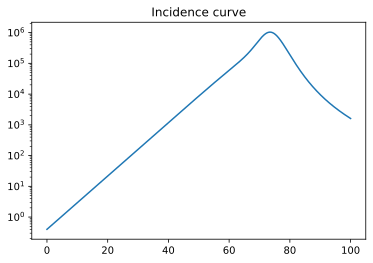

In [ ]:
model = f.loadModel('SIR_vars')

solution, t_span = f.solve(model, (0, 100), 100)

infsScaled = f.infCurve(model, solution, t_span)
plt.plot(t_span, infsScaled, label='Infections')
plt.title('Incidence curve')

plt.yscale('log')

plt.show()


Writing model to file models/SIR_vars.json.
Overwriting file.
Writing model to file models/SIR_vars_mod.json.
Overwriting file.
{'Rt(S,I_A)': 1.9979957793160512, 'Rt(S,I_B)': 0.0}


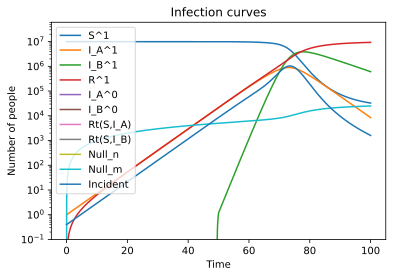

In [ ]:
importlib.reload(f)

model, model_mod, initialConds, R0 = f.computeR0(
    "SIR_vars", write=True, overWrite=True, whereToAdd='contact',
    printInit=False, printText=False)

print(R0)

newModel = f.mod(model, False, False)
solution, t_span = f.solve(newModel, (0, 100), 100)

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=list(range(solution.shape[1])),
             labels=f.getCompartments(newModel))
plt.plot(t_span, f.infCurve(newModel, solution, t_span), label='Incident')
plt.yscale('log')
plt.ylim(bottom=.1)
plt.legend(loc='best')
plt.show()


In [ ]:
importlib.reload(f)

name = 'SIR_test'
measures = {
    'layerDistance': '2cm',
    'nodeDistance': '2cm',
    'varDistance': '.5cm',
    'nullDistance': '.8cm',
    'baseAngle': 10,
    'contactPositions': ("2/5", "3/5")
}

# f.printModel(f.loadModel(name, True, False))

f.createLaTeX(f.loadModel(name, True, False), **measures)

f.createLaTeX(f.mod(f.loadModel(name, True, False),
                    overWrite=True), **measures)


Overwriting file.
This code doesn't work for 3 variants or more yet.
This code doesn't work for 3 variants or more yet.
This code doesn't work for 3 variants or more yet.
Overwriting file.
Overwriting file.
This code doesn't work for 3 variants or more yet.
This code doesn't work for 3 variants or more yet.
This code doesn't work for 3 variants or more yet.
This code doesn't work for 3 variants or more yet.
This code doesn't work for 3 variants or more yet.
This code doesn't work for 3 variants or more yet.
